# Generative Adversarial Networks (GANs)

In [1]:
import os
import numpy as np

import keras
from keras import layers
from keras.preprocessing import image
from keras.datasets import fashion_mnist


import matplotlib.pyplot as plt


%matplotlib inline

Using TensorFlow backend.


## Loading the data

In [2]:
(X_train, y_train), (_, _) = fashion_mnist.load_data()
X_train = X_train[y_train==7]
## cropping mostly whites from images
X_train = X_train[:,np.arange(6,22),:]

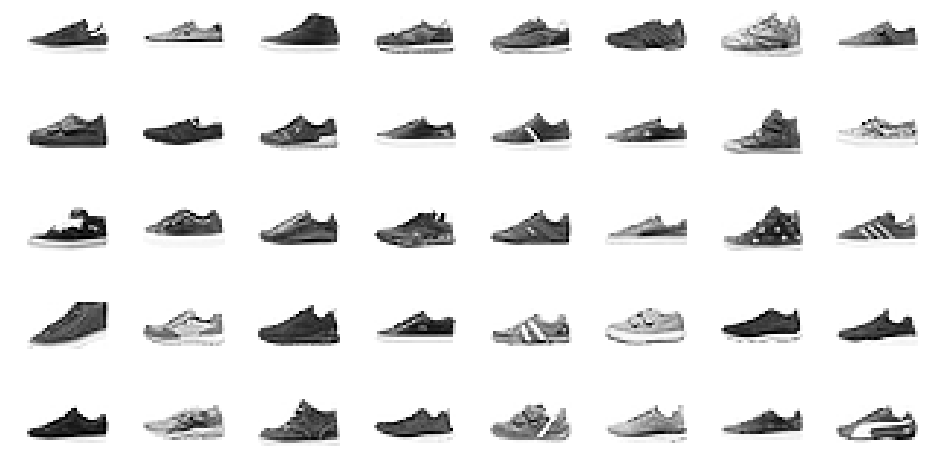

In [3]:
fig, axes = plt.subplots(nrows=5, ncols=8, figsize=(13,7))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(X_train[i], cmap='Greys')
    ax.axis('off')

fig.tight_layout()

## Generator

In [4]:
latent_dim = 32
height = 16
width = 28
channels = 1

In [5]:
X_train = X_train.reshape((X_train.shape[0],) + (height, width, channels)).astype('float32') / 255.

In [6]:
input_feat_maps = 64
gen_filters = 256
generator_input = keras.Input(shape=(latent_dim,))

x = layers.Dense(8 * 14 * input_feat_maps)(generator_input) 
x = layers.LeakyReLU()(x)                        
x = layers.Reshape((8, 14, input_feat_maps))(x)

# Convolutional layer
x = layers.Conv2D(filters=gen_filters, kernel_size=5, padding='same')(x)
x = layers.LeakyReLU()(x)

## Deconvolution
x = layers.Conv2DTranspose(gen_filters, kernel_size=4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(gen_filters, 5, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(gen_filters, 5, padding='same')(x)
x = layers.LeakyReLU()(x)

x = layers.Conv2D(filters=channels, kernel_size=7, activation='tanh', padding='same')(x)
generator = keras.models.Model(generator_input, x)
generator.summary() 

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 32)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 7168)              236544    
_________________________________________________________________
leaky_re_lu_1 (LeakyReLU)    (None, 7168)              0         
_________________________________________________________________
reshape_1 (Reshape)          (None, 8, 14, 64)         0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 8, 14, 256)        409856    
_________________________________________________________________
leaky_re_lu_2 (LeakyReLU)    (None, 8, 14, 256)        0         
_________________________________________________________________
conv2d_transpose_1 (Conv2DTr (None, 16, 28, 256)       1048832   
__________

## Discriminator

In [7]:
disc_filters = 64
discriminator_input = layers.Input(shape=(height, width, channels))
x = layers.Conv2D(disc_filters, 3)(discriminator_input)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(disc_filters, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(disc_filters, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Conv2D(disc_filters, 4, strides=2, padding='same')(x)
x = layers.LeakyReLU()(x)
x = layers.Flatten()(x)

x = layers.Dropout(0.4)(x)
x = layers.Dense(1, activation='sigmoid')(x)
discriminator = keras.models.Model(discriminator_input, x)
discriminator.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 16, 28, 1)         0         
_________________________________________________________________
conv2d_5 (Conv2D)            (None, 14, 26, 64)        640       
_________________________________________________________________
leaky_re_lu_6 (LeakyReLU)    (None, 14, 26, 64)        0         
_________________________________________________________________
conv2d_6 (Conv2D)            (None, 7, 13, 64)         65600     
_________________________________________________________________
leaky_re_lu_7 (LeakyReLU)    (None, 7, 13, 64)         0         
_________________________________________________________________
conv2d_7 (Conv2D)            (None, 4, 7, 64)          65600     
_________________________________________________________________
leaky_re_lu_8 (LeakyReLU)    (None, 4, 7, 64)          0         
__________

In [8]:
learning_rate = 6e-05
discriminator_optimizer = keras.optimizers.RMSprop(lr=learning_rate, clipvalue=1.0, decay=1e-8)
discriminator.compile(optimizer=discriminator_optimizer, loss='binary_crossentropy')

## Adversarial Network

In [9]:
discriminator.trainable = False
gan_input = keras.Input(shape=(latent_dim,))
gan_output = discriminator(generator(gan_input))
gan = keras.models.Model(gan_input, gan_output)
gan_optimizer = keras.optimizers.RMSprop(lr=learning_rate/2, clipvalue=1.0, decay=1e-8)
gan.compile(optimizer=gan_optimizer, loss='binary_crossentropy')

## Training the GAN

In [10]:
iterations = 6000
batch_size = 20

save_dir = './data/gan_produced_images'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [11]:
start = 0
disc_loss = []
adv_loss = []
for step in range(iterations):
    # Sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Decode them to fake images
    generated_images = generator.predict(random_latent_vectors)

    # Combine them with real images
    stop = start + batch_size
    real_images = X_train[start: stop]
    combined_images = np.concatenate([generated_images, real_images])

    # Assemble labels discriminating real from fake images, reals are 1s
    labels = np.concatenate([np.zeros((batch_size, 1)),
                             np.ones((batch_size, 1))])
    # Add random noise to the labels - important trick!
    labels = labels + 0.05 * np.random.random(labels.shape)

    # Train the discriminator
    d_loss = discriminator.train_on_batch(combined_images, labels)

    # sample random points in the latent space
    random_latent_vectors = np.random.normal(size=(batch_size, latent_dim))

    # Assemble labels that say "all real images"
    misleading_targets = np.ones((batch_size, 1))

    # Train the generator (via the gan model,
    # where the discriminator weights are frozen)
    a_loss = gan.train_on_batch(random_latent_vectors, misleading_targets)
    
    start += batch_size
    if start > (len(X_train) - batch_size):
        start = 0

    # Occasionally save / plot
    if step % 100 == 0:
        # Save model weights
        gan.save_weights('./SavedModels/gan.h5')
        disc_loss.append(d_loss)
        adv_loss.append(a_loss)

        # Print metrics
        print("Step {}, discriminant loss: {:0.4f}, adversarial loss: {:0.4f}".format(step, d_loss, a_loss))
        # Save one generated image
#        img = image.array_to_img(generated_images[0] * 255., scale=False)
#        img.save(os.path.join(save_dir, 'img_step_' + str(step) + '.png'))

C:\Users\direc\Anaconda3\envs\recipes-ai\lib\site-packages\keras\engine\training.py:973: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'


Step 0, discriminant loss: 0.6840, adversarial loss: 0.6937
Step 100, discriminant loss: 0.6277, adversarial loss: 0.6666
Step 200, discriminant loss: 0.6360, adversarial loss: 0.6363
Step 300, discriminant loss: 0.6365, adversarial loss: 0.6864
Step 400, discriminant loss: 0.6127, adversarial loss: 0.7775
Step 500, discriminant loss: 0.6306, adversarial loss: 0.7921
Step 600, discriminant loss: 0.5620, adversarial loss: 0.7895
Step 700, discriminant loss: 0.5348, adversarial loss: 0.8633
Step 800, discriminant loss: 0.5992, adversarial loss: 0.9604
Step 900, discriminant loss: 0.5541, adversarial loss: 0.5840
Step 1000, discriminant loss: 0.6350, adversarial loss: 0.6481
Step 1100, discriminant loss: 0.6680, adversarial loss: 1.0022
Step 1200, discriminant loss: 0.5820, adversarial loss: 0.8537
Step 1300, discriminant loss: 0.6600, adversarial loss: 0.9862
Step 1400, discriminant loss: 0.5983, adversarial loss: 0.6493
Step 1500, discriminant loss: 0.5712, adversarial loss: 0.7341
Step

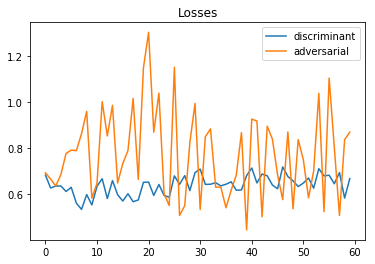

In [50]:
plt.plot(disc_loss, label='discriminant')
plt.plot(adv_loss, label='adversarial')
plt.title("Losses")
plt.legend();

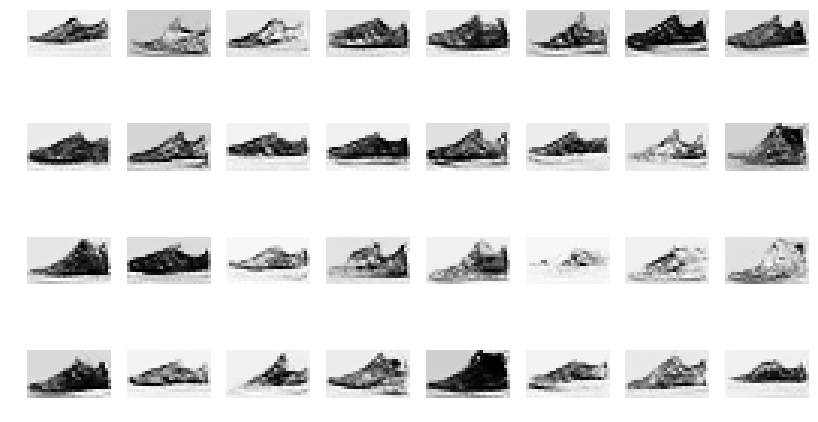

In [49]:
more_shoes = generator.predict(np.random.normal(size=(32, latent_dim)))
fig, axes = plt.subplots(nrows=4, ncols=8, figsize=(14,8))
for i, ax in enumerate(axes.flatten()):
    ax.imshow(more_shoes[i].reshape(16,28), cmap='Greys')
    ax.axis('off')

Most of the code on this notebook is based on:

Chollet, F. (2017) [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python). Manning.

Original Paper on GANS:

[Generative Adversarial Networks](https://arxiv.org/pdf/1406.2661.pdf): 
Ian J. Goodfellow, Jean Pouget-Abadie, Mehdi Mirza, Bing Xu, David Warde-Farley, Sherjil Ozair, Aaron Courville, Yoshua Bengio